# Data Storytelling

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
import numpy as np
import datetime as dt

In [27]:
# Import and touch up data
sp500 = pd.read_csv("Data/SP500.csv")
sp500.set_index('Unnamed: 0', inplace = True)
sp500.index.names = ['date']
sp500.set_index(pd.to_datetime(sp500.index), inplace = True)

sp500[sp500 == np.inf] = 0
sp500[sp500 == -np.inf] = 0

# Remove MMM because it has weird properties
sp500.drop('MMM', axis=1, inplace=True)

In [28]:
# Function to plot pretty histograms
def get_dist_graph(data, column, bins = 1000, title="Histogram"):
    fig, ax = plt.subplots(1, figsize=(15, 10))
    data_to_visualize = data[column][~data[column].isin([np.nan, np.inf, -np.inf])]
    mean = data_to_visualize.mean()
    std = data_to_visualize.std()
    minimum = data_to_visualize.min()
    maximum = data_to_visualize.max()
    sns.distplot(data_to_visualize, bins = bins, label = 'Mean : ' + str(round(mean, 2)))
    plt.xlim(max(mean - (3*std), minimum), min(mean + (3*std), maximum))
    plt.axvline(mean)
    plt.legend()
    plt.title(title)

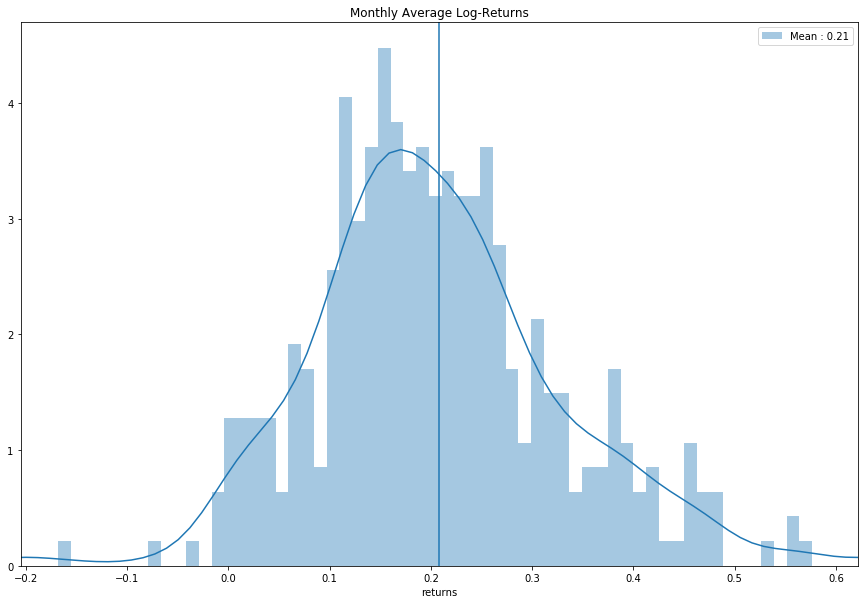

In [29]:
# Average annual returns
sp500_full = sp500.drop(sp500.index[0])
sp500_full.dropna(axis =1, how='any', inplace=True)
avg_ar = sp500_full.groupby(sp500_full.index.month).sum().mean().to_frame(name='returns')
get_dist_graph(avg_ar, 'returns', bins=100, title='Monthly Average Log-Returns')

In [30]:
# Create the index average returns
sp500_index = sp500.sum(axis=1)
sp500_index.head()

date
1999-01-04    0.000000
1999-01-05    3.287302
1999-01-06    6.703803
1999-01-07   -1.260266
1999-01-08    1.530566
dtype: float64

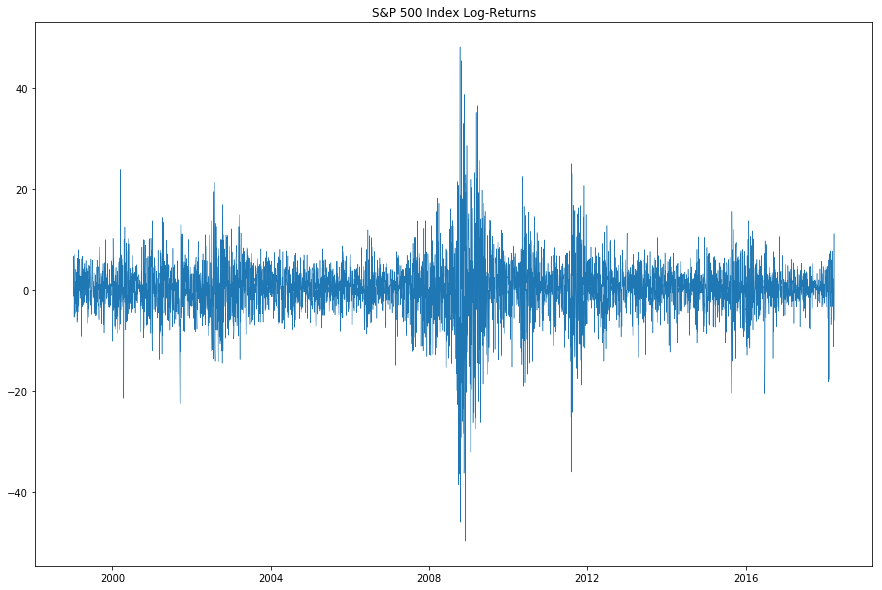

In [31]:
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.lineplot(data=sp500_index, palette="tab10", linewidth=.5)
plt.title("S&P 500 Index Log-Returns")
plt.show()

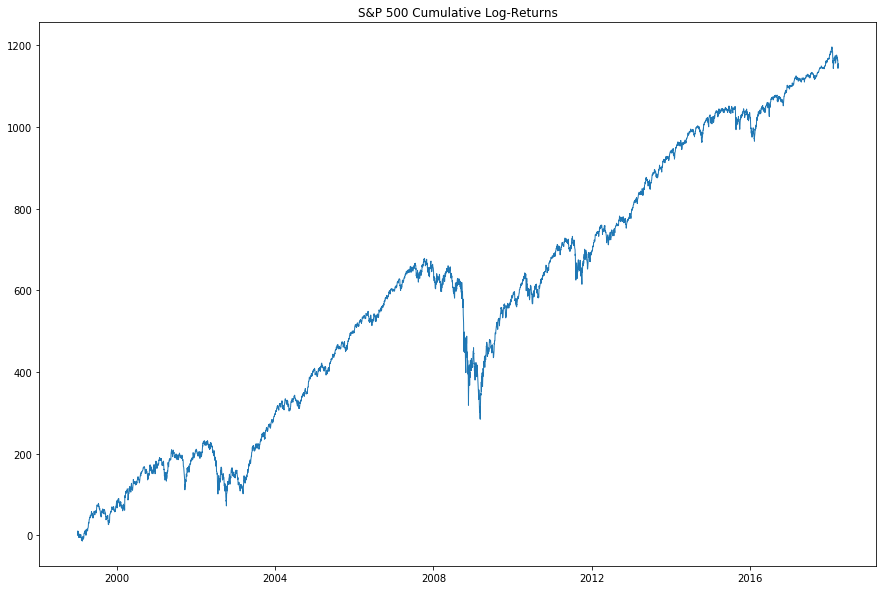

In [32]:
sp500_indexcumul = sp500_index.cumsum()
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.lineplot(data=sp500_indexcumul, palette="tab10", linewidth=1)
plt.title("S&P 500 Cumulative Log-Returns")
plt.show()

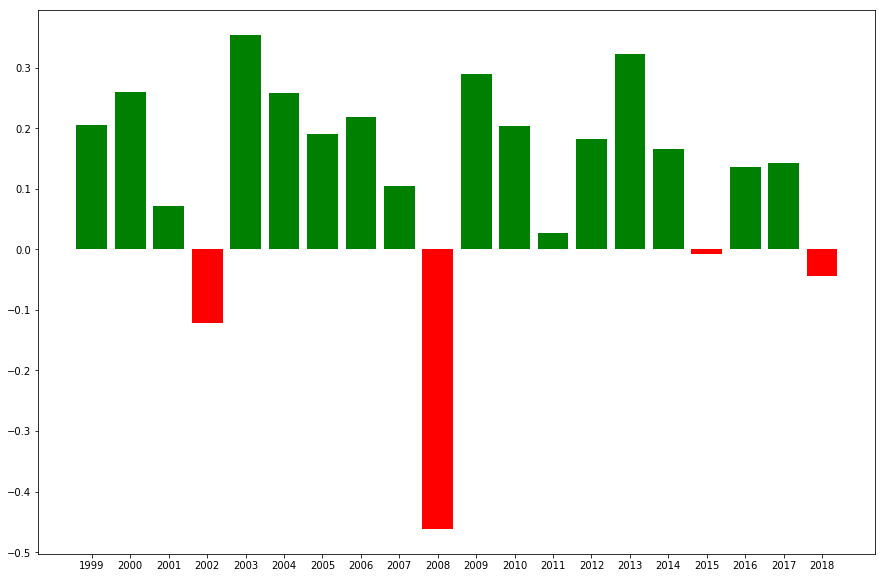

In [57]:
avg_year_ret = sp500_full.groupby(sp500_full.index.year).sum().mean(axis=1)
green = avg_year_ret > 0
fig, ax = plt.subplots(1, figsize=(15, 10))
plt.bar(avg_year_ret.index[green], height=avg_year_ret[green], color="green")
plt.bar(avg_year_ret.index[~green], height=avg_year_ret[~green], color="red")
plt.xticks(avg_year_ret.index)
plt.show()